In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:


# Diretórios e parâmetros
diretorio_base = './pets'
tamanho_imagem = (224, 224)
batch_size = 32

# Aumento de Dados
gerador_treinamento = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Divisão para validação
)

fluxo_treinamento = gerador_treinamento.flow_from_directory(
    diretorio_base,
    target_size=tamanho_imagem,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

fluxo_validacao = gerador_treinamento.flow_from_directory(
    diretorio_base,
    target_size=tamanho_imagem,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Modelo 1: Transfer Learning com VGG16
base_modelo_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_modelo_vgg16.trainable = False

modelo_vgg16 = Sequential([
    base_modelo_vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(fluxo_treinamento.num_classes, activation='softmax')
])

# Descongelar as últimas camadas da VGG16 para ajuste fino
for camada in base_modelo_vgg16.layers[-4:]:
    camada.trainable = True


modelo_vgg16.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# VGG16 com ajuste fino
historico_vgg16_finetune = modelo_vgg16.fit(fluxo_treinamento, validation_data=fluxo_validacao, epochs=20, verbose=1)


Found 576 images belonging to 6 classes.
Found 144 images belonging to 6 classes.
Epoch 1/20


c:\Users\welli\anaconda3\envs\finaiti\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 444s 21s/step - accuracy: 0.1451 - loss: 2.0613 - val_accuracy: 0.2014 - val_loss: 1.8168
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 400s 19s/step - accuracy: 0.1255 - loss: 1.9846 - val_accuracy: 0.2431 - val_loss: 1.7703
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 396s 19s/step - accuracy: 0.2206 - loss: 1.8251 - val_accuracy: 0.3611 - val_loss: 1.7143
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 381s 18s/step - accuracy: 0.2466 - loss: 1.7698 - val_accuracy: 0.4375 - val_loss: 1.6622
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 356s 17s/step - accuracy: 0.3046 - loss: 1.7005 - val_accuracy: 0.4861 - val_loss: 1.5983
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 358s 17s/step - accuracy: 0.3539 - loss: 1.5939 - val_accuracy: 0.5278 - val_loss: 1.5271
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 354s 17s/step - accuracy: 0.4026 - loss: 1.5121 - val_accuracy: 0.5208 - val_loss: 1.4378
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 355s 17s/step - accuracy: 0.4598 - loss: 1.3712 - val_accuracy: 0.5347 - val_

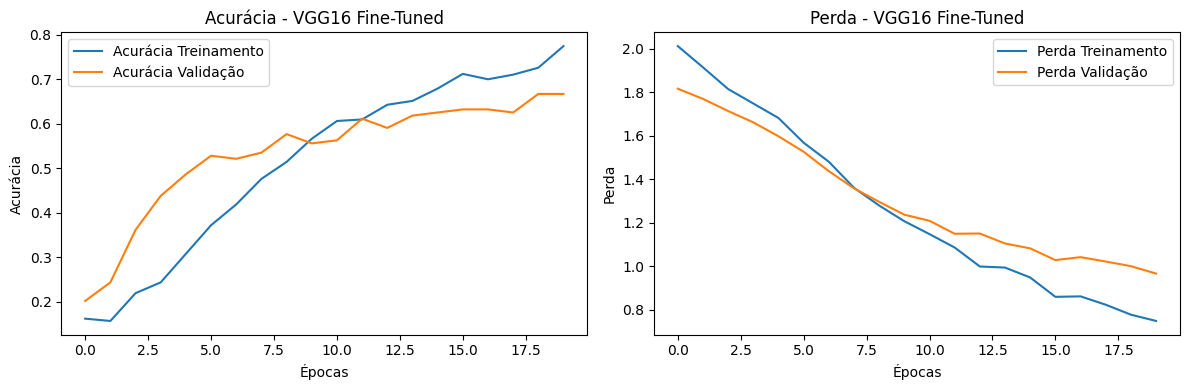

In [4]:


# Função para plotar os gráficos de acurácia e perda
def plotar_graficos(historico, titulo):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(historico.history['accuracy'], label='Acurácia Treinamento')
    plt.plot(historico.history['val_accuracy'], label='Acurácia Validação')
    plt.title(f'Acurácia - {titulo}')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(historico.history['loss'], label='Perda Treinamento')
    plt.plot(historico.history['val_loss'], label='Perda Validação')
    plt.title(f'Perda - {titulo}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plotar_graficos(historico_vgg16_finetune, 'VGG16 Fine-Tuned')


In [5]:

# Função para prever uma nova imagem
def prever_imagem(modelo, caminho_imagem, classes):
    imagem = load_img(caminho_imagem, target_size=tamanho_imagem)
    imagem_array = img_to_array(imagem) / 255.0
    imagem_array = np.expand_dims(imagem_array, axis=0)
    
    previsao = modelo.predict(imagem_array)
    indice_classe = np.argmax(previsao)
    classe_predita = classes[indice_classe]
    
    plt.imshow(imagem)
    plt.title(f'Predição: {classe_predita}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


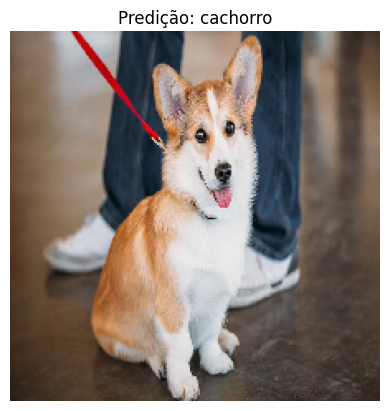

In [9]:


classes = list(fluxo_treinamento.class_indices.keys())
caminho_imagem_teste = './teste/teste2.jpg'  # caminho da sua imagem de teste
prever_imagem(modelo_vgg16, caminho_imagem_teste, classes)



In [ ]:
# Avaliação do modelo VGG16
avaliacao_vgg16 = modelo_vgg16.evaluate(fluxo_validacao, verbose=0)
print(f"Desempenho VGG16: Acurácia = {avaliacao_vgg16[1]}")

Desempenho VGG16: Acurácia = 0.6180555820465088
